In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bharatadhikari","key":"7ded38126f3924f3839ae69b011499ec"}'}

In [ ]:
# create a kaggle folder
!mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to the folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

 99% 324M/329M [00:03<00:00, 121MB/s]
100% 329M/329M [00:03<00:00, 99.1MB/s]


In [ ]:
# unzip
!unzip plant-village.zip


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch,label_batch in dataset.take(1): # display properties of batch 1st
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 0 0 1 0 1 1 1 1 1 2 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 2]


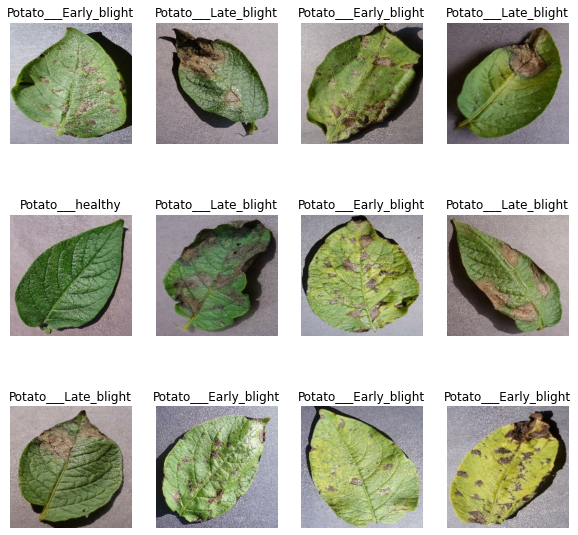

In [ ]:
plt.figure(figsize= (10,10))
for image_batch ,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
# train_size = 0.8
# len(dataset)*train_size

In [ ]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split =0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed =2)
  train_size = int(train_split * ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [ ]:
#this will read image from disk and keep in memory for next operation
# this will increase performance 
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
                    
])

In [ ]:
data_augmentation =tf.keras.Sequential([
                                        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                        layers.experimental.preprocessing.RandomRotation(0.2),
])

# Making a CNN model

In [ ]:
input_shape= (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes= len(dataset.class_names)
model = models.Sequential([
                           resize_and_rescale,
                           data_augmentation,
                           layers.Conv2D(32,kernel_size = (3,3),activation = 'relu',input_shape = (IMAGE_SIZE,IMAGE_SIZE)),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,kernel_size =(3,3),activation = 'relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,kernel_size =(3,3),activation = 'relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,kernel_size =(3,3),activation = 'relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64,kernel_size =(3,3),activation = 'relu'),
                           layers.MaxPooling2D((2,2)),   
                           layers.Conv2D(64,kernel_size =(3,3),activation = 'relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Flatten(),
                           layers.Dense(64,activation = 'relu'),
                           layers.Dense(n_classes, activation = 'softmax'),                                                                
])



In [ ]:
model.build(input_shape= input_shape)

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_12 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_54 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [ ]:
model.compile(
    optimizer = 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose= 1,
    validation_data = val_ds

)

Epoch 1/50
54/54 [==============================] - 8s 98ms/step - loss: 0.9218 - accuracy: 0.4800 - val_loss: 0.8655 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 3s 64ms/step - loss: 0.8164 - accuracy: 0.5827 - val_loss: 0.8169 - val_accuracy: 0.6094
Epoch 3/50
54/54 [==============================] - 3s 60ms/step - loss: 0.5802 - accuracy: 0.7523 - val_loss: 0.7540 - val_accuracy: 0.7240
Epoch 4/50
54/54 [==============================] - 3s 61ms/step - loss: 0.4195 - accuracy: 0.8157 - val_loss: 0.2857 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.3554 - accuracy: 0.8597 - val_loss: 0.5594 - val_accuracy: 0.7656
Epoch 6/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2480 - accuracy: 0.8955 - val_loss: 0.1769 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2493 - accuracy: 0.9038 - val_loss: 0.2748 - val_accuracy: 0.9010
Epoch 8/50
54

In [ ]:
test_eval = model.evaluate(test_ds)

8/8 [==============================] - 2s 24ms/step - loss: 0.0937 - accuracy: 0.9531


In [ ]:
print('test accuracy ( loss, accuracy): ', test_eval)

test accuracy ( loss, accuracy):  [0.09367866814136505, 0.953125]


In [ ]:
history

In [ ]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# history.history['val_accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

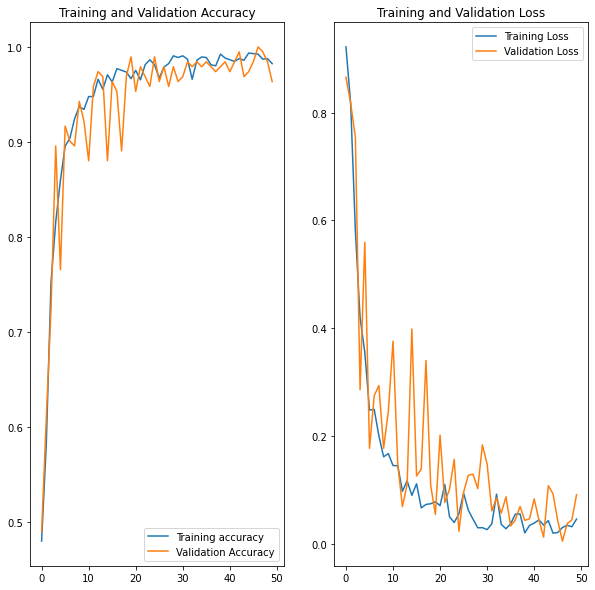

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label : Potato___Late_blight
Potato___Late_blight


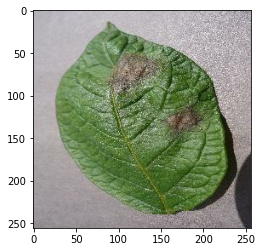

In [ ]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label :', class_names[first_label])
  batch_prediction = model.predict(image_batch)
  print(class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Predict function create
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

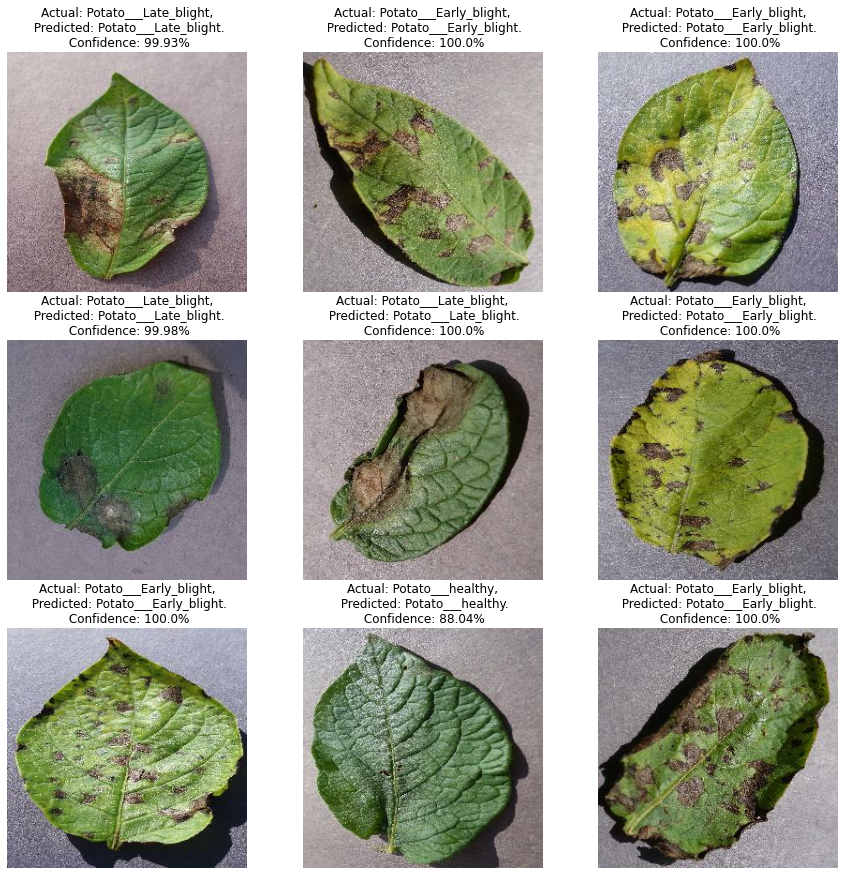

In [ ]:
# subplot
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save('model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

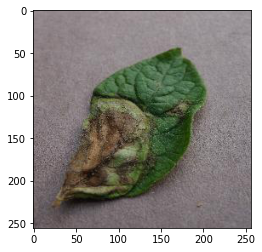

In [ ]:
label = {0:'early_disease',1:'late_disease',2:'healthy'}
#healthy
img_path ='/content/PlantVillage/PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG'
img1 = image.load_img(img_path)
plt.imshow(img1)
img = image.load_img(img_path, target_size = (256,256,3))
x = image.img_to_array(img)
# x = np.expand_dims(x,axis = 0)



In [ ]:
preds =model.predict(x)
preds_list=list(preds[0])
max_value = max(preds_list)
req_index = preds_list.index(max_value)
print(f'prediction class: {label[req_index]} , accuracy : {round(max_value,2)}')

prediction class: healthy , accuracy : 1.0


In [ ]:
#Gradcam
late_output = model.output[:,1]
last_conv_layer = model.get_layer('conv2d_59')

In [ ]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap

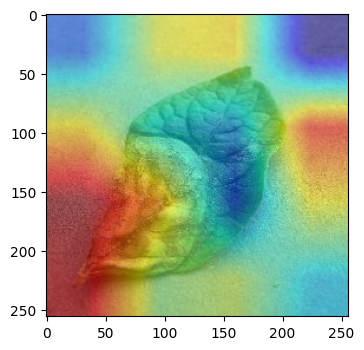

In [ ]:

# Load Your Favourite Image
# test_img = img_to_array(load_img("monkey.jpeg" , target_size=(224,224)))

# Use The Function - Boom!
VizGradCAM(model, x)

gradcam.py   model.h5       plant-village.zip
kaggle.json  PlantVillage/  sample_data/


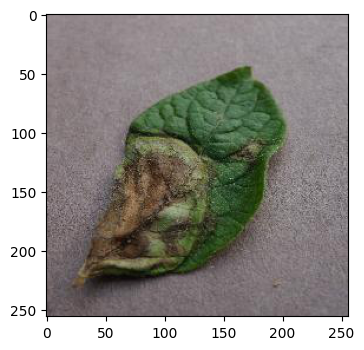

In [ ]:
_img = tensorflow.keras.preprocessing.image.load_img('/content/PlantVillage/PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG')
# ',target_size=(224,224))
plt.imshow(_img)
plt.show()

In [ ]:
#preprocess image to get it into the right format for the model
img = tensorflow.keras.preprocessing.image.img_to_array(_img)
img = img.reshape((1, *img.shape))
y_pred = model.predict(img)

In [ ]:
layers = [layer.output for layer in model.layers]


In [ ]:
images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

In [ ]:
grads.shape


TensorShape([1, 256, 256, 3])

In [ ]:
dgrad_abs = tf.math.abs(grads)


In [ ]:
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]


In [ ]:
dgrad_max_.shape


(256, 256)

In [ ]:
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

In [ ]:
grad_eval.shape


(256, 256)

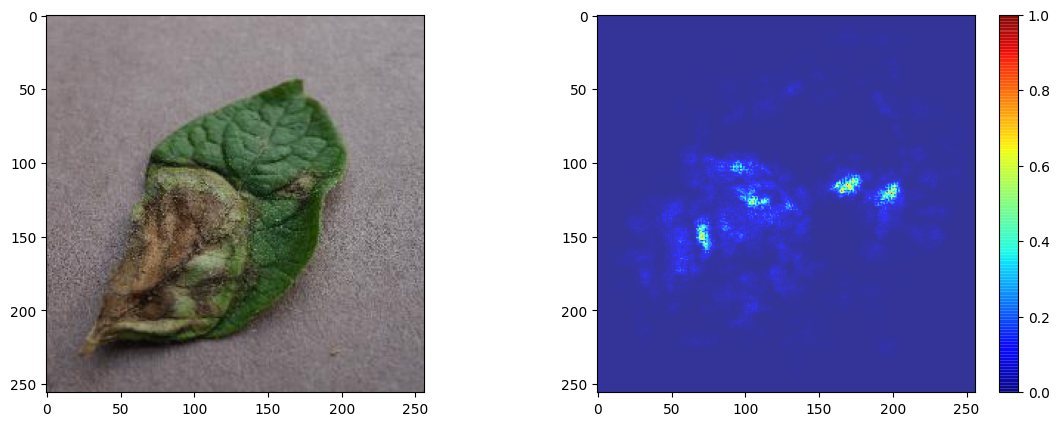

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

In [ ]:
from PIL import Image

def saliency_map(img):
  _img = tensorflow.keras.preprocessing.image.load_img(img,target_size=(256,256))

  '''
  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(_img)
  i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
  fig.colorbar(i) '''
  #preprocess image to get it into the right format for the model
  img = tensorflow.keras.preprocessing.image.img_to_array(_img)
  img = img.reshape((1, *img.shape))
  y_pred = model.predict(img)
  layers = [layer.output for layer in model.layers]
  images = tf.Variable(img, dtype=float)

  with tf.GradientTape() as tape:
      pred = model(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]
      
  grads = tape.gradient(loss, images)
  #grads.shape
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]


  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(_img)
  axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
  # plt.axis('off')
  fig.colorbar(i)
  im1 = _img
  im2 = Image.fromarray(grad_eval)

  # grad_eval =Image.fromarray(grad_eval)
  # grad_eval.save('alpha.jpg')
  # newimg = Image.blend(im1, im2, alpha=0.5)
  # newimg.save("blended.jpg")
  


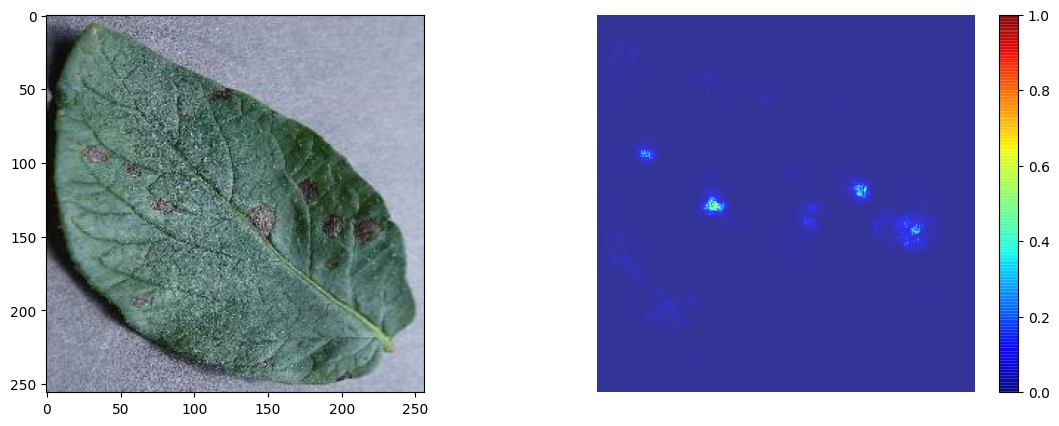

In [ ]:
saliency_map('/content/PlantVillage/PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG')

In [ ]:
from PIL import Image
im1 = Image.open()
im2 = Image.open('')

newimg = Image.blend(im1, im2, alpha=0.5)
plt.imshow(newimg)

AttributeError: ignored

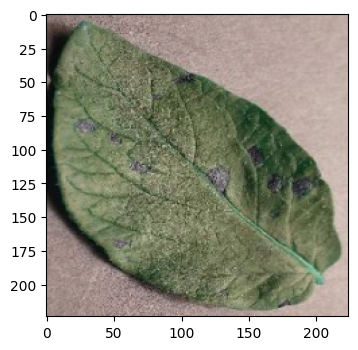

In [ ]:
pneumonia=cv2.imread('/content/PlantVillage/PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG')

r_pneumonia = cv2.resize(pneumonia,(224,224),cv2.INTER_AREA)
plt.imshow(r_pneumonia)

In [ ]:

keys={0:'early',1:'late',2:'healthy'}

In [ ]:
def model_modifier(m):
  m.layers[-1].activation=tf.keras.activations.linear
  return m
  





In [ ]:
# Defining a function to generate saliency graphs for the top 3 predicted classes
def saliency_graphs(model, img):

  # Create Saliency object
  saliency = Saliency(model, model_modifier)

  # input image that is pre-processed
  input_image = img

  # predict on the input image
  y_pred = model.predict(input_image)

  # return the indices in decreasing order of predicted probability
  class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

  for i, class_idx in enumerate(class_idxs_sorted[:3]):

    # Define loss function for the class label.
    # The 'output' variable refer to the output of the model
    loss = lambda output: tf.keras.backend.mean(output[:, class_idx])   

    # Generate saliency map with smoothing. Smoothing reduces noise in the Saliency map
    # smooth_samples is the number of calculating gradients iterations
    saliency_map = saliency(loss, input_image[0,...], smooth_samples=20,smooth_noise=0.20)    
    saliency_map = normalize(saliency_map)
    plot_saliency_map(saliency_map,img,y_pred,i,class_idx)

In [ ]:
# Defining a function to plot saliency map
def plot_saliency_map(sal_map, img, y_pred, i, class_idx):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ax[0].imshow(r_covid)
  j = ax[1].imshow(sal_map[0],cmap="jet",alpha=0.8)
  fig.colorbar(j)
  for axe in ax:
    axe.grid(False)
    axe.axis('off')
  plt.suptitle("Predicted(class={}) = {:5.2f}".format(keys[class_idx],y_pred[0,class_idx]))

In [ ]:
saliency_graphs(model,_img)

NameError: ignored